In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, learning_curve, validation_curve
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

### Data preprocessing

In [ ]:
dataset = pd.read_csv('data/sleep.csv')
dataset.isnull().sum(axis=0)/dataset.shape[0]*100 #percentage of missing data for each column

Person ID                   0.00000
Gender                      0.00000
Age                         0.00000
Occupation                  0.00000
Sleep Duration              0.00000
Quality of Sleep            0.00000
Physical Activity Level     0.00000
Stress Level                0.00000
BMI Category                0.00000
Blood Pressure              0.00000
Heart Rate                  0.00000
Daily Steps                 0.00000
Sleep Disorder             58.55615
dtype: float64

We can see that we got missing values only in the Sleep Disorder column: those are not missing values, they're just indicating that the subject has no disease.

We do not need the Person ID, so we are going to drop it (it's just a progressive index).

In [ ]:
person_id = 'Person ID'
dataset = dataset.drop(person_id, axis=1)

Now, before splitting the data into features and target label, we assign:
-- 0 -> no disease
-- 1 -> Insomnia
-- 2 -> Sleep Apnea
And since the Blood Pressure is represented as an object of the type systolic/diastolic, we add two integer columns (one for systolic and one for diastolic) and we drop the original column.

In [ ]:
#sleep disorder mapping
sleep_disorder = dataset['Sleep Disorder']

sleep_disorder = sleep_disorder.fillna('None')
sleep_disorder = sleep_disorder.map({ 'None' : 0, 'Insomnia' : 1, 'Sleep Apnea' : 2})
dataset['Sleep Disorder'] = sleep_disorder

#blood pressure splitting
blood_pressure = dataset['Blood Pressure']

parts = blood_pressure.str.split('/', expand=True)
systolic = parts[0]
diastolic = parts[1]

dataset = dataset.drop('Blood Pressure', axis=1)
dataset['Systolic'] = systolic.astype(int)
dataset['Diastolic'] = diastolic.astype(int)

In [ ]:
X = dataset.drop('Sleep Disorder', axis=1)
y = dataset['Sleep Disorder']

Let's check if the target label has imbalanced classes.

In [ ]:
distribution = y.value_counts(normalize=True)
print(distribution)

Sleep Disorder
0    0.585561
2    0.208556
1    0.205882
Name: proportion, dtype: float64


As we can see the target label class is moderate imbalanced, we are going to keep track of this for the future.

### Definition of the Data Transformation Pipeline

As we know there are no missing value, so we proceed with:
-- Gender -> OneHotEncoder
-- Age -> StandardScaler
-- Occupation -> OneHotEncoder
-- Sleep Duration (hours) -> StandardScaler
-- Quality of Sleep (scale: 1-10) -> StandardScaler
-- Physical Activity Level (minutes/day) -> StandardScaler
-- Stress Level (scale: 1-10) -> StandardScaler
-- BMI Category -> OneHotEncoder
-- Diastolic -> StandardScaler
-- Systolic -> StandardScaler
-- Heart Rate (bpm) -> StandardScaler
-- Daily Steps -> Standard Scaler

In [ ]:
pipeline_scaler = Pipeline([
    ('scaler', StandardScaler())
])

pipeline_onehot = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(
    transformers=[
        ('gender', pipeline_onehot, ['Gender']),
        ('age', pipeline_scaler, ['Age']),
        ('occupation', pipeline_onehot, ['Occupation']),
        ('sleep_duration', pipeline_scaler, ['Sleep Duration']),
        ('quality_of_sleep', pipeline_scaler, ['Quality of Sleep']),
        ('physical_activity_level', pipeline_scaler, ['Physical Activity Level']),
        ('stress_level', pipeline_scaler, ['Stress Level']),
        ('bmi_category', pipeline_onehot, ['BMI Category']),
        ('blood_pressure', pipeline_scaler, ['Diastolic', 'Systolic']),
        ('heart_rate', pipeline_scaler, ['Heart Rate']),
        ('daily_steps', pipeline_scaler, ['Daily Steps']),
    ],
    verbose_feature_names_out=False
)

### Training and test sets

Since we have few columns and rows, we use the 80-20 split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

### Model Selection

Let's proceed by defining a starting model or pipeline.
-- data transformation -> the final transformation created before
-- dimensionality reduction -> PCA
-- handling imbalanced classes -> SMOTE
-- classification -> Random Forest

In [ ]:
model_pipeline = IMBPipeline([
    ('data_transformation', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components = 0.95)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42)),
])

In [ ]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_transformation',
                 ColumnTransformer(transformers=[('gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('age',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('occupation',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Occupation']),
                                                 ('sleep_duration',
                                                  Pipeline(st...
                                                                   StandardScaler())]),
                                                  ['Diastolic', 'Systolic']),
                                                 ('heart_rate',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Heart Rate']),
                                                 ('daily_steps',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Daily Steps'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.95)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [ ]:
model_pipeline.predict(X_test) #generate predictions for X_test using the trained model_pipeline

array([2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 1, 2, 1, 0, 2, 0, 0, 2,
       0, 1, 0, 2, 1, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 0, 0,
       0, 2, 0, 2, 0, 0, 1, 2, 1])

For each step of the pipeline model_pipeline, we define a list of admissible parameter distributions.

In [ ]:
sampler_config = [
    {
        'sampler': [None]},
    {
        'sampler': [SMOTE(n_jobs=-1)],  # Upsampling using SMOTE
        'sampler__sampling_strategy': [1, 0.7, 0.5],  # Consider smaller class proportions for more balanced sampling
        'sampler__k_neighbors': [3, 5, 9],  # Default neighbor counts for SMOTE
    },
    {
        'sampler': [RandomOverSampler()],  # Random oversampling
        'sampler__sampling_strategy': [1, 0.7, 0.5],  # Sampling ratios to consider
    },
]

dim_reduction_config = [
    {
        'dim_reduction': [None]},  # No dimensionality reduction
    {
        'dim_reduction': [PCA()],  # PCA for variance maximization
        'dim_reduction__n_components': [0.7, 0.9],  # Keep 70% or 90% variance, reduces features
    },
    {
        'dim_reduction': [LDA()],  # LDA for class separation
        'dim_reduction__n_components': [1, 3, 5],  # Try reducing dimensions, note: n_components must be <= number of classes-1
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv=3, scoring='f1_macro')],  # SFS with Perceptron as the estimator
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],  # Additional estimators for SFS
        'dim_reduction__k_features': [5, 10, 13],  # Select subsets of 5, 10, or all features (13 features in total)
    }
]

classifier_config = [
    {
        'classifier': [None]},  # No classifier
    {
        'classifier': [RandomForestClassifier(n_jobs=-1)],  # Random Forest Classifier to reduce overfitting
        'classifier__n_estimators': [10, 50, 100],  # Vary the number of estimators
    },
    {
        'classifier': [Perceptron(n_jobs=-1)],  # Perceptron: a linear classifier
        'classifier__eta0': loguniform(0.01, 10),  # Log-uniform distribution for eta0 (learning rate)
        'classifier__penalty': ['l1', 'l2'],  # L1/L2 regularization
    },
    {
        'classifier': [KNeighborsClassifier(n_jobs=-1)],  # KNN classifier
        'classifier__n_neighbors': [1, 3, 5],  # Number of neighbors to consider
    },
    {
        'classifier': [LogisticRegression(n_jobs=-1)],  # Logistic Regression
        'classifier__C': loguniform(0.01, 10),  # Log-uniform distribution for regularization strength
        'classifier__penalty': ['l1', 'l2'],  # L1/L2 regularization
    }
]

Now we build a list of all possible configurations to be passed to RandomSearchCV object.

In [ ]:
all_configs = [dict(itertools.chain(*(e.items()
for e in configuration)))
for configuration
in itertools.product(sampler_config,dim_reduction_config,classifier_config)]
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 60'

Now, we can use nested-cross validation to identify 5 different best candidates to be our reference model. First, we define a RandomizedSearchCV (allows us to explore the search space more efficiently and potentially find a good configuration faster, respect to the GridSearchCV) object which takes the list of all configurations, use a 2-fold cross validation using F1 as scoring metric.

In [ ]:
rs = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs),
    cv=2,
    scoring='f1_macro',
    n_jobs=-1,
)

In [ ]:
scores = cross_validate(rs, X_train, y_train, cv=5, scoring='f1_macro', return_estimator=True, verbose=3)

[CV] END ......................................., score=0.833 total time=  16.6s
[CV] END ......................................., score=0.983 total time=  29.5s
[CV] END ......................................., score=0.877 total time=  25.7s
[CV] END ......................................., score=0.824 total time=  14.7s
[CV] END ......................................., score=0.844 total time=  34.4s


Now, using a for loop we visualise the step of the model pipeline and the final score, so to get an overview of the performances of the best models.

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'], estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('\n')

None
PCA(n_components=0.9)
KNeighborsClassifier(n_jobs=-1, n_neighbors=3) {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.8333333333333334


None
SequentialFeatureSelector(cv=3, estimator=LogisticRegression(),
                          k_features=(5, 5), scoring='f1_macro')
RandomForestClassifier(n_jobs=-1) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9828234031132581


None
PCA(n_components=0.9)
LogisticRegression(C=5.885475703226322, n_jobs=-1) {'C': 5.885475703226322, 'class_weight': None, 'dual': False, 'fit_intercept'

To further reduce the number of candidates we re-train the above model model on the entire training set and evaluate their performance on the test set. In our case we select the third configuration because it has the less difference between F1-Test and F1-train among the ones with the highest score.

In [ ]:
for estimator in scores['estimator']:
    p_train = estimator.best_estimator_.fit(X_train, y_train)
    p_train = estimator.best_estimator_.predict(X_train)
    p_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, p_train, average='macro')
    f1_test = f1_score(y_test, p_test, average='macro')
    print(f'F1 training:{f1_train}, F1 test:{f1_test}')

F1 training:0.8916406909539581, F1 test:0.8212523414893695
F1 training:0.9062176518443179, F1 test:0.8386627906976744
F1 training:0.890327263060351, F1 test:0.8141539129490937
F1 training:0.8741032782202028, F1 test:0.8636968766001024
F1 training:0.8102764590267336, F1 test:0.7578842940685045


### Refinement of the selected model

We first define the pipeline of the selected model (which is the last one of the ones above) and then we define a RandomisedSearchCV object to identify the best configuration.

In [ ]:
best_model_pipeline = IMBPipeline([
    ('final_transformation', final_transformation),
    ('dim_reduction',PCA()),
    ('classifier', LogisticRegression(n_jobs=-1)),
])

params = {
    'dim_reduction__n_components': [0.7, 0.9],
    'classifier__C': loguniform(0.01, 10),
}

rs_best = RandomizedSearchCV(
    estimator=best_model_pipeline,
    param_distributions=params,
    n_iter=30,
    n_jobs=-1,
    scoring='f1_macro'
)

In [ ]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('final_transformation',
                                              ColumnTransformer(transformers=[('gender',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender']),
                                                                              ('age',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age']),
                                                                              ('occupation',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Occupation'])...
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Daily '
                                                                                'Steps'])],
                                                                verbose_feature_names_out=False)),
                                             ('dim_reduction', PCA()),
                                             ('classifier',
                                              LogisticRegression(n_jobs=-1))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4bc9e60a60>,
                                        'dim_reduction__n_components': [0.7,
                                                                        0.9]},
                   scoring='f1_macro')

Now we can compute the F1-score on the test set.

In [ ]:
rs_best.best_estimator_

Pipeline(steps=[('final_transformation',
                 ColumnTransformer(transformers=[('gender',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('age',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('occupation',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Occupation']),
                                                 ('sleep_duration',
                                                  Pipeline(s...
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Diastolic', 'Systolic']),
                                                 ('heart_rate',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Heart Rate']),
                                                 ('daily_steps',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Daily Steps'])],
                                   verbose_feature_names_out=False)),
                ('dim_reduction', PCA(n_components=0.9)),
                ('classifier',
                 LogisticRegression(C=0.14119848876631802, n_jobs=-1))])

In [ ]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test), average='macro')

0.8225108225108224

Now, we can visualise the learning curve and the validation curve to quantify the bias/variance trade-off as a function of the size of the training set and the variation of the hyperparameters k_features and n_estimators, for the case of Logistic Regression.

(10.0, 150.0)

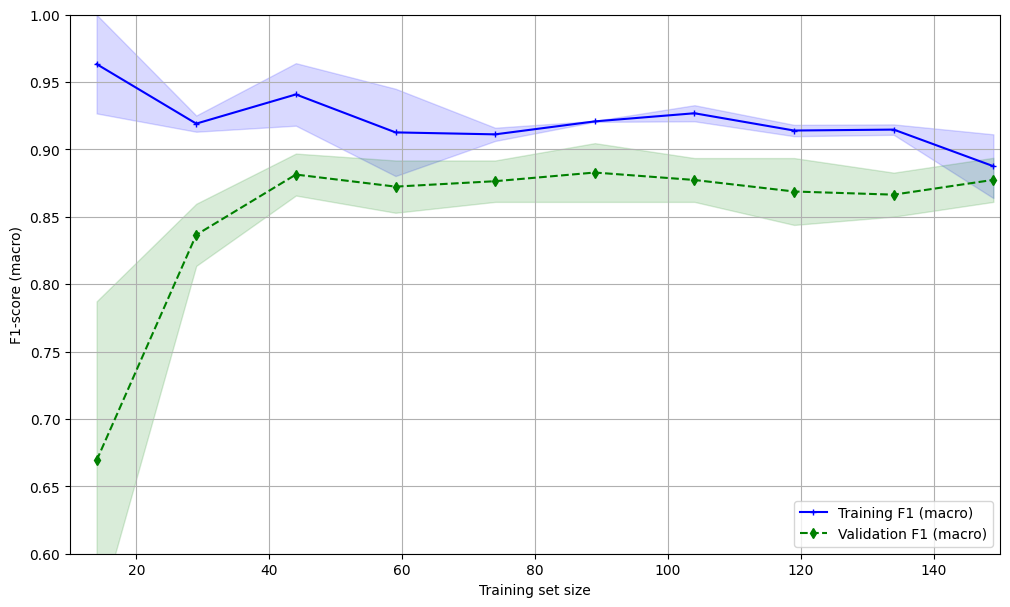

In [ ]:
cls = rs_best.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 2,
                                                       n_jobs = -1,
                                                       scoring = 'f1_macro',
                                                       shuffle = False)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training F1 (macro)')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation F1 (macro)')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score (macro)')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.0])
ax.set_xlim([10, 150])

While not severe, the gap between training and validation F1 suggests a possibility of slight overfitting. This means the model might be learning the training data too well, potentially at the expense of generalizing to new data.

(0.01, 100)

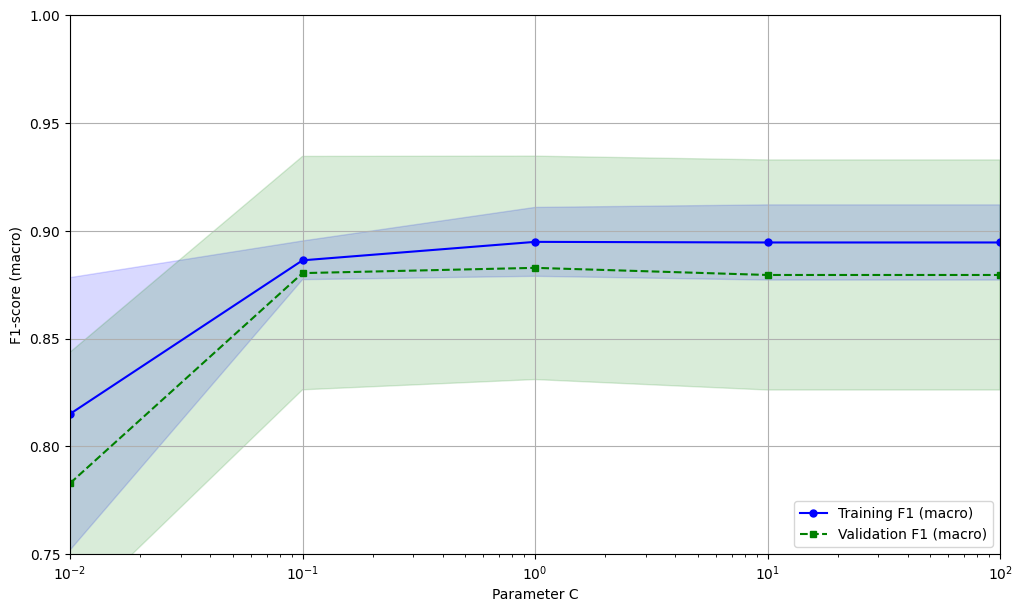

In [ ]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train,
        y=y_train,
        param_range=
        range_C,
        param_name='classifier__C',
        cv=5,
        n_jobs=-1,
        scoring='f1_macro'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training F1 (macro)')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation F1 (macro)')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score (macro)')
ax.legend(loc='lower right')
ax.set_ylim([0.75, 1])
ax.set_xscale('log')
ax.set_xlim([0.01,100])

The validation F1-score appears to be highest in the range of C values around 1 to 10. This suggests that the optimal regularization strength for the model lies within this range.
The validation F1 curve is relatively flat across a range of C values, especially between 1 and 100. This suggests that the model's performance is not drastically sensitive to small changes in C within this range.

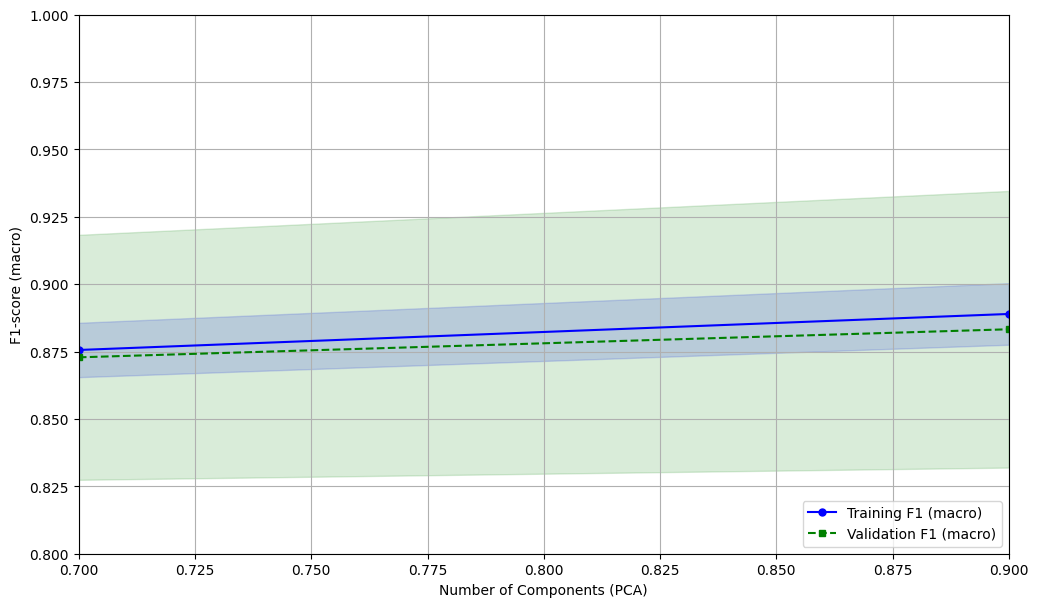

In [ ]:
# Define the parameter range for PCA n_components
range_components = [0.7, 0.9]

# Assuming you already have your classifier and pipeline set up with PCA as part of the pipeline
# Example: cls is a pipeline that has 'dim_reduction' and 'classifier'

train_scores, test_scores = validation_curve(
    cls,
    X=X_train,
    y=y_train,
    param_range=range_components,
    param_name='dim_reduction__n_components',  # The parameter name for PCA components in the pipeline
    cv=5,
    n_jobs=-1,
    scoring='f1_macro'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Create the plot for the validation curve
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

# Plot training F1-score (macro) with error shading
ax.plot(range_components, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training F1 (macro)')
ax.fill_between(range_components,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

# Plot validation F1-score (macro) with error shading
ax.plot(range_components, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation F1 (macro)')
ax.fill_between(range_components,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

# Formatting the plot
ax.grid()
ax.set_xlabel('Number of Components (PCA)')
ax.set_ylabel('F1-score (macro)')
ax.legend(loc='lower right')
ax.set_ylim([0.8, 1])  # Adjust the y-axis range for better visualization
ax.set_xscale('linear')  # PCA components usually are on a linear scale
ax.set_xlim([0.7, 0.9])  # Adjust the x-axis range to fit the n_components values (0.7 and 0.9)

plt.show()